# Forecasting prices

## Overview

Train several models to see what's the better performance.

Models:

* KNN
* ARIMA Model
* Bagging
* Boosting

## Import libraries

In [19]:
import sys
!{sys.executable} -m  conda install -c anaconda scikit-learn

Solving environment: done

# All requested packages already installed.



In [28]:
import datetime as dt
import os
import pandas as pd
import numpy as np
import csv
import warnings

# Plot
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# ARIMA
from statsmodels.tsa.arima_model import ARIMA

#Bagging
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#Neural Network
from sklearn.neural_network import MLPClassifier


# Add plotly for interactive charts
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.graph_objs as go
from plotly import tools



## Initial variables

In [3]:
symbol = "AABA"

## Reading data from CSV file

In [4]:
# Get values from cvs file
filename = "data/" + symbol + ".csv"
headers = ["date", symbol]
portf_value = pd.read_csv(filename, sep=",", names = headers)
portf_value.set_index("date", inplace= True)

In [5]:
# Normalize the prices Dataframe
normed = portf_value.copy()

In [6]:
# Convert price column to float
normed[symbol] = pd.to_numeric(normed[symbol], errors='coerce').fillna(0)

In [7]:
normed.info()
normed.head()

<class 'pandas.core.frame.DataFrame'>
Index: 126 entries, date to 2019-01-11
Data columns (total 1 columns):
AABA    126 non-null float64
dtypes: float64(1)
memory usage: 2.0+ KB


,AABA
date,
date,0.000000
2018-07-16,74.660004
2018-07-17,75.360001
2018-07-18,74.660004
2018-07-19,73.360001


## Getting indicator values

## ARIMA Model

In [25]:
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error

In [26]:
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

In [29]:
# evaluate parameters
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(series.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=24.927
ARIMA(0, 0, 1) MSE=8.214
ARIMA(0, 0, 2) MSE=3.401
ARIMA(0, 1, 0) MSE=2.031
ARIMA(0, 1, 1) MSE=2.239
ARIMA(0, 1, 2) MSE=4.172
ARIMA(0, 2, 0) MSE=3.202
ARIMA(0, 2, 1) MSE=3.383
ARIMA(0, 2, 2) MSE=2.942
ARIMA(1, 0, 0) MSE=2.588
ARIMA(1, 0, 1) MSE=3.160
ARIMA(1, 0, 2) MSE=2.753
ARIMA(1, 1, 0) MSE=2.102
ARIMA(1, 2, 0) MSE=3.335
ARIMA(2, 1, 0) MSE=2.309
ARIMA(2, 2, 0) MSE=3.411
ARIMA(2, 2, 1) MSE=4.181
ARIMA(4, 0, 0) MSE=2.563
ARIMA(4, 1, 0) MSE=2.153
ARIMA(4, 1, 1) MSE=2.472
ARIMA(4, 2, 0) MSE=3.086
ARIMA(6, 0, 1) MSE=3.108
ARIMA(6, 1, 0) MSE=2.195
ARIMA(6, 1, 1) MSE=2.191
ARIMA(6, 1, 2) MSE=5.428
ARIMA(6, 2, 0) MSE=2.765
ARIMA(8, 0, 0) MSE=2.999
ARIMA(8, 0, 1) MSE=2.978
ARIMA(8, 0, 2) MSE=3.097
ARIMA(8, 1, 0) MSE=3.076
ARIMA(8, 1, 1) MSE=3.148
ARIMA(8, 1, 2) MSE=3.849
ARIMA(8, 2, 0) MSE=4.572
ARIMA(10, 0, 0) MSE=3.076
ARIMA(10, 1, 0) MSE=3.137
ARIMA(10, 1, 1) MSE=3.352
ARIMA(10, 2, 0) MSE=5.501
Best ARIMA(0, 1, 0) MSE=2.031


predicted=64.375608, expected=62.480000
predicted=63.232771, expected=60.980000
predicted=61.705952, expected=59.950001
predicted=60.655295, expected=61.209999
predicted=61.921743, expected=62.279999
predicted=62.995861, expected=64.389999
predicted=65.121704, expected=63.590000
predicted=64.304494, expected=62.220001
predicted=62.911334, expected=60.889999
predicted=61.559120, expected=62.150002
predicted=62.825546, expected=62.400002
predicted=63.070970, expected=64.370003
predicted=65.054790, expected=64.160004
predicted=64.835372, expected=65.430000
predicted=66.111563, expected=64.419998
predicted=65.084122, expected=65.589996
predicted=66.259282, expected=66.820000
predicted=67.494949, expected=64.800003
predicted=65.448003, expected=63.860001
predicted=64.492278, expected=63.009998
predicted=63.627743, expected=62.230000
predicted=62.834175, expected=62.570000
predicted=63.171635, expected=62.820000
predicted=63.418286, expected=62.759998
predicted=63.352073, expected=62.009998


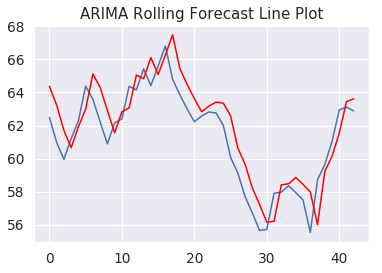

In [85]:

from pandas import Series
series =  pd.Series(normed[symbol].values)

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
plt.plot(test)
plt.plot(predictions, color='red')
plt.title("ARIMA Rolling Forecast Line Plot")
plt.show()

                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                  124
Model:                 ARIMA(0, 1, 0)   Log Likelihood                -414.017
Method:                           css   S.D. of innovations              6.820
Date:                Thu, 17 Jan 2019   AIC                            832.033
Time:                        20:46:10   BIC                            837.674
Sample:                             1   HQIC                           834.324
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5090      0.612      0.831      0.408      -0.691       1.709


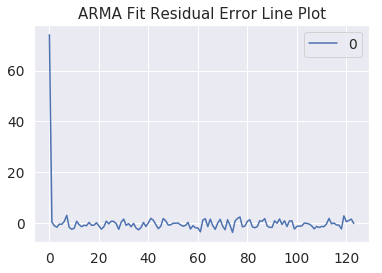

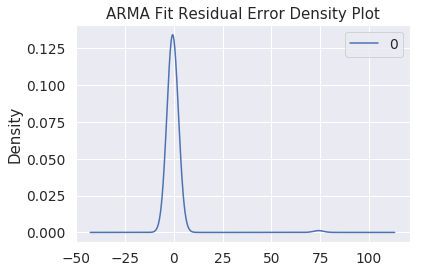

                  0
count  1.240000e+02
mean   9.463756e-16
std    6.847974e+00
min   -3.848948e+00
25%   -1.543951e+00
50%   -7.589516e-01
75%    5.510471e-01
max    7.415105e+01


In [95]:
print(model_fit.summary())
# plot residual errors
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.title("ARMA Fit Residual Error Line Plot")
plt.show()
residuals.plot(kind='kde')
plt.title("ARMA Fit Residual Error Density Plot")
plt.grid("on")
plt.show()
print(residuals.describe())

## RMS

In [86]:
rms=np.sqrt(np.mean(np.power((np.array(history)-np.array(predictions)),2)))
print('RMS: ', rms)

RMS:  8.644035506873553


## 4. Save an ARIMA Time Series Forecasting Model

The statsmodels library provides an implementation of ARIMA for use in Python. ARIMA models can be saved to file for later use in making predictions on new data. There is a bug in the earlier versions to 0.9 of the statsmodels library that prevents saved models from being loaded.


In [87]:
import statsmodels
print('statsmodels: %s' % statsmodels.__version__)

statsmodels: 0.9.0


In [88]:
from statsmodels.tsa.arima_model import ARIMAResults

# save model
model_fit.save('arima_model.pkl')
# load model
loaded = ARIMAResults.load('arima_model.pkl')

In [91]:
start_d = "2019-01-11"
start_d = dt.datetime.strptime(start_d, '%Y-%m-%d')

end_d = '2019-01-18'
end_d = dt.datetime.strptime(end_d, '%Y-%m-%d')

# Calculate steps
days = (end_d - start_d).days
print(days)
forecast = loaded.forecast(steps=days)[0] 

# Setting dates for dataframe
dates = pd.date_range(start_d, periods=days)


df=pd.DataFrame(forecast)
df['Dates'] = dates
df.set_index('Dates', inplace=True)
df.rename(columns = {0:'Price'}, inplace=True)


7


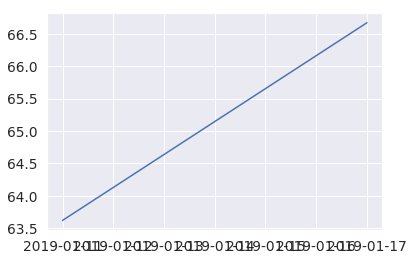

In [93]:
# plot
plt.plot(df)
